## Clio demo

In [2]:
# Import libraries
import os
import sys
import pandas as pd
import json, base64
import numpy as np
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Import project APIs
from preprocessing import decode_row_to_turns, xml_transform
from facet_extraction import run_facets_on_dataframe, ClaudeClient
from clustering import embed_facets, run_kmeans, assign_clusters, summarize_clusters
from cluster_naming import name_all_clusters, NamingParams
from projector import ProjectorParams, project_and_merge, plot_projection
from hierarchizer_demo import HierParams, build_hierarchy

---

### 1. Data Preprocessing

Data flow: BASE64 → decoded JSON → Python turns list → XML → Stored in chats_xml.csv

In [5]:
# Load data
df = pd.read_csv("sample_data.csv") # Change to your data path here
df.head()

,id,created_dttm,title,tags,encoded_content
0,bf7a26d1-c317-4d9b-a709-6e6593c5914c,2025-10-09T04:38,회의 일정 조정,event_planning-arts,eyJ0dXJucyI6IFt7InJvbGUiOiAidXNlciIsICJ0ZXh0Ij...
1,d44033ab-e35d-4fb5-98b8-b03ceadf7810,2025-10-14T08:10,Holiday Party Planning,health-social_services-communication,eyJ0dXJucyI6IFt7InJvbGUiOiAidXNlciIsICJ0ZXh0Ij...
2,918bca10-eabb-4cf7-9cba-6f1890d1929f,2025-10-02T05:50,Bug Reproduction Steps,operations-staffing,eyJ0dXJucyI6IFt7InJvbGUiOiAidXNlciIsICJ0ZXh0Ij...
3,4562ae6e-cdad-4a66-bcb6-9a2d4bfc9f7b,2025-10-03T12:50,Coverage Schedule Swap,operations-staffing,eyJ0dXJucyI6IFt7InJvbGUiOiAidXNlciIsICJ0ZXh0Ij...
4,3a4d9586-7eb4-47d5-b230-03863570d590,2025-10-06T18:02,DAU Weekly Report,hr-people_ops,eyJ0dXJucyI6IFt7InJvbGUiOiAidXNlciIsICJ0ZXh0Ij...


In [7]:
# Decode to structured turns
df["turns"] = df["encoded_content"].apply(decode_row_to_turns)
df[["turns"]].head(3)

,turns
0,"[{'role': 'user', 'text': 'Can you help draft ..."
1,"[{'role': 'user', 'text': 'Can you help draft ..."
2,"[{'role': 'user', 'text': 'Please outline a 3-..."


In [9]:
# Convert each conversation to XML
df["conversation_xml"] = df.apply(
    lambda r: xml_transform(
        chat_id=r["id"],
        timestamp=r["created_dttm"],
        title=r.get("tags", ""),
        turns=r.get("turns", []),
    ),
    axis=1
)

df[["conversation_xml"]].head(3)

,conversation_xml
0,"<conversation id=""bf7a26d1-c317-4d9b-a709-6e65..."
1,"<conversation id=""d44033ab-e35d-4fb5-98b8-b03c..."
2,"<conversation id=""918bca10-eabb-4cf7-9cba-6f18..."


In [ ]:
# Save to CSV
df_out = df[["id", "conversation_xml"]].copy() # Change "chat_id" to your column name here
df_out.to_csv("data/chats_xml.csv", index=False)

---
### 2. Extract facets

- Used Claude 3.5 Haiku here (as in paper) - should be switched to in-house LLM
- This step takes the most time
- Only using 100 chats since local processing is too slow, update with full data when having access to HPC
- De-identifying happens at this step
- [TODO] "language" facet needs some future debugging, if useful

In [4]:
# Check if API Key is set (using Anthropic for this demo with my own API key)
print(os.getenv("ANTHROPIC_API_KEY") is not None)
client = ClaudeClient()

True


In [ ]:
# Load xml data we prepared
df_xml = pd.read_csv("data/chats_xml.csv")  
df_xml.head(3)

,id,conversation_xml
0,bf7a26d1-c317-4d9b-a709-6e6593c5914c,"<conversation id=""bf7a26d1-c317-4d9b-a709-6e65..."
1,d44033ab-e35d-4fb5-98b8-b03ceadf7810,"<conversation id=""d44033ab-e35d-4fb5-98b8-b03c..."
2,918bca10-eabb-4cf7-9cba-6f1890d1929f,"<conversation id=""918bca10-eabb-4cf7-9cba-6f18..."


In [46]:
# Using a smaller subset here because it's taking too long for me locally
df_xml_small = df_xml.head(100)

In [48]:
# Extract facets (~ min for 1000 sample data rows)
facets_df = run_facets_on_dataframe(df_xml_small, client=client) # replace "df_xml_small" with "df_xml" when having HPC
facets_df.head()

,id,request,language,task,concerning
0,bf7a26d1-c317-4d9b-a709-6e6593c5914c,The user's overall request for the assistant i...,,The task is to draft a concise summary and act...,2
1,d44033ab-e35d-4fb5-98b8-b03ceadf7810,The user's overall request for the assistant i...,,The task is to draft a concise summary and act...,2
2,918bca10-eabb-4cf7-9cba-6f1890d1929f,The user's overall request for the assistant i...,,The task is to outline a 3-day itinerary with ...,2
3,4562ae6e-cdad-4a66-bcb6-9a2d4bfc9f7b,The user's overall request for the assistant i...,,The task is to brainstorm ways to visualize qu...,2
4,3a4d9586-7eb4-47d5-b230-03863570d590,The user's overall request for the assistant i...,,The task is to draft a concise summary and act...,2


In [ ]:
facets_df.to_csv("data/facets.csv", index=False)

----
### 3. Embedding + Clustering + Naming

- using "all-mpnet-base-v2" for embedding as is in the paper
- Choosing k for clustering is tricky and details are not known from paper, see my implementation in "clustering.py"
- [TODO] whether summary and name are both needed, it seems a bit redundant

In [34]:
# Check if all-mpnet-base-v2 is loaded
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2")
print("Model loaded.")

Model loaded.


In [ ]:
# Embed request facet
facets = pd.read_csv("data/facets.csv")
df_req, X = embed_facets(facets, text_column="request")
np.save("embeddings.npy", X)

# Clustering
labels, k = run_kmeans(X)
print("Chosen k:", k)

Chosen k: 3


In [36]:
# Assign cluster IDs
clustered_df = assign_clusters(df_req, labels)
clustered_df.head()

,id,request,language,task,concerning,cluster_id
0,bf7a26d1-c317-4d9b-a709-6e6593c5914c,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1
1,d44033ab-e35d-4fb5-98b8-b03ceadf7810,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1
2,918bca10-eabb-4cf7-9cba-6f1890d1929f,The user's overall request for the assistant i...,NaN,The task is to outline a 3-day itinerary with ...,2.0,2
3,4562ae6e-cdad-4a66-bcb6-9a2d4bfc9f7b,The user's overall request for the assistant i...,NaN,The task is to brainstorm ways to visualize qu...,2.0,1
4,3a4d9586-7eb4-47d5-b230-03863570d590,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1


In [12]:
# Summary
summary_df = summarize_clusters(clustered_df)
summary_df

,cluster_id,count
1,1,44
0,0,31
2,2,25


In [ ]:
# Preparing parameters for naming clusters
params = NamingParams(
    text_col="request",  
    cluster_col="cluster_id",
    in_cluster_n=50,
    out_cluster_n=50,
    random_state=123,
    save_dir="artifacts/naming",
)

# Model used for naming
# Since it's already de-identified, can keep using claude
client = ClaudeClient(model="claude-3-5-sonnet-20240620") 

# Naming clusters
names_df = name_all_clusters(
    df=clustered_df,
    embeddings=X,
    complete_fn=client.complete, 
    params=params
)

names_df.to_csv("data/cluster_names.csv", index=False)
names_df.head()

,cluster_id,summary,name
0,0,Participants requested or discussed topics mat...,Summarize Assistant User's Overall Request
1,1,Participants requested or discussed topics mat...,Summarize User's Overall Request Assistant
2,2,Participants requested or discussed topics mat...,Summarize Assistant Request User's Overall


In [ ]:
# Merge and save data

clustered_named = clustered_df.merge(names_df, on="cluster_id", how="left")
clustered_named.to_csv("data/clustered_named.csv", index=False)
clustered_named.head()

,id,request,language,task,concerning,cluster_id,summary,name
0,bf7a26d1-c317-4d9b-a709-6e6593c5914c,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1,Participants requested or discussed topics mat...,Summarize User's Overall Request Assistant
1,d44033ab-e35d-4fb5-98b8-b03ceadf7810,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1,Participants requested or discussed topics mat...,Summarize User's Overall Request Assistant
2,918bca10-eabb-4cf7-9cba-6f1890d1929f,The user's overall request for the assistant i...,NaN,The task is to outline a 3-day itinerary with ...,2.0,2,Participants requested or discussed topics mat...,Summarize Assistant Request User's Overall
3,4562ae6e-cdad-4a66-bcb6-9a2d4bfc9f7b,The user's overall request for the assistant i...,NaN,The task is to brainstorm ways to visualize qu...,2.0,1,Participants requested or discussed topics mat...,Summarize User's Overall Request Assistant
4,3a4d9586-7eb4-47d5-b230-03863570d590,The user's overall request for the assistant i...,NaN,The task is to draft a concise summary and act...,2.0,1,Participants requested or discussed topics mat...,Summarize User's Overall Request Assistant


---
### 4. Projector for visualization

- visually verify that clusters are well-separated
- spot outliers or noisy points
- get intuition about the semantic structure

In [ ]:
# Load data from previous step
X = np.load("embeddings.npy")
clustered_named = pd.read_csv("data/clustered_named.csv")

In [10]:
# Set up projector
proj_params = ProjectorParams(n_neighbors=5, min_dist=0.1, random_state=123)
clustered_proj = project_and_merge(clustered_named, X, proj_params)

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


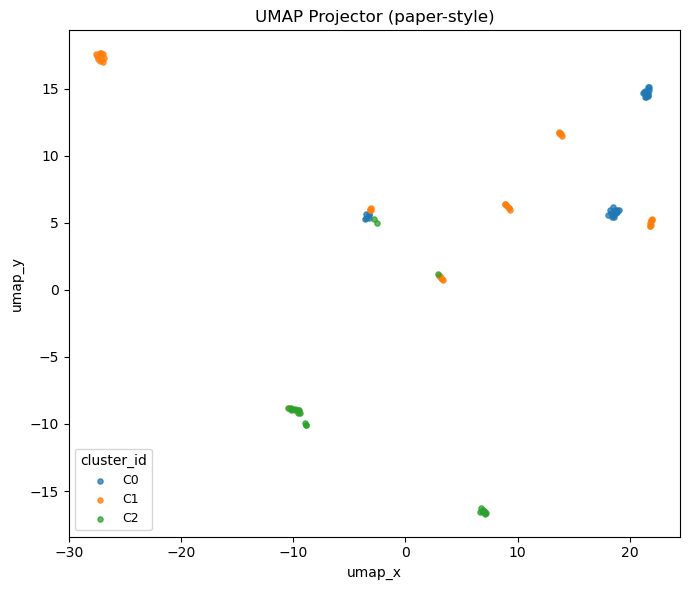

In [12]:
# Projector visualization
plot_projection(clustered_proj, cluster_col="cluster_id")

---
### 5. Hierarchizer
- Building a tree-strcture for clusters, ranking and visualize them

In [26]:
hier_params = HierParams(
    text_col="request",
    cluster_col="cluster_id",
    save_dir="artifacts/hierarchy"
)

hierarchy = build_hierarchy(clustered_named, X, hier_params)
hierarchy

{'meta': {'n_clusters': 3,
  'n_parents': 1,
  'params': {'text_col': 'request',
   'cluster_col': 'cluster_id',
   'n_parents': None,
   'distance_threshold': None,
   'linkage': 'average',
   'random_state': 42,
   'save_dir': 'artifacts/hierarchy'}},
 'parents': [{'parent_id': 0,
   'child_cluster_ids': [0, 1, 2],
   'parent_summary': '',
   'parent_name': ''}]}

#### Cluster Hierarchy (Demo)

**Parent 0**

- **Cluster 0** — *<cluster 0 name here>*
- **Cluster 1** — *<cluster 1 name here>*
- **Cluster 2** — *<cluster 2 name here>*